In [1]:
import torch

import os
os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4)
    ]

@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # -----------------------------------------------------------
    # Add some integer bound assumptions.
    # This helps to guide integer analysis in the backend to optimize
    # load/store offset address calculation
    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16 #tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `matmul_kernel`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)


# %%
# We can now create a convenience wrapper function that only takes two input tensors,
# and (1) checks any shape constraint; (2) allocates the output; (3) launches the above kernel.


def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        ACTIVATION=activation  #
    )
    return c

In [5]:
# BLOCK_SIZE_M = BLOCK_SIZE_K = 16
@triton.jit
def matmul_trellis_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # -----------------------------------------------------------
    # Add some integer bound assumptions.
    # This helps to guide integer analysis in the backend to optimize
    # load/store offset address calculation
    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M // 4 + tl.arange(0, BLOCK_SIZE_M // 4)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16 #tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        print(a)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        print(b)
        raise
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def matmul_trellis(a_trellis_compressed, b):
    # Check constraints.
    assert a_trellis_compressed.shape[1] * 4 == b.shape[0], "Incompatible dimensions"
    assert a_trellis_compressed.is_contiguous(), "Matrix A must be contiguous"
    M = a_trellis_compressed.shape[0]
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a_trellis_compressed.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    
    #BLOCK_SIZE_M = 16
    #BLOCK_SIZE_N = 16
    grid = lambda META: (triton.cdiv(M, 16) * triton.cdiv(N, 16), )
    matmul_trellis_kernel[grid](
        a_trellis_compressed, b, c,  #
        M, N, K,  #
        a_trellis_compressed.stride(0), a_trellis_compressed.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        BLOCK_SIZE_M = 16, 
        BLOCK_SIZE_N = 16,
        BLOCK_SIZE_K = 16,  #
        GROUP_SIZE_M = 1,
    )
    return c

In [8]:
def decode_uint16_to_int4_python(bits):
    bits = bits.to(torch.int32)
    val0 = (bits >> 12) & 0xF
    val1 = (bits >> 8) & 0xF
    val2 = (bits >> 4) & 0xF
    val3 = bits & 0xF

    sign0 = (val0 & 0x8) != 0
    sign1 = (val1 & 0x8) != 0
    sign2 = (val2 & 0x8) != 0
    sign3 = (val3 & 0x8) != 0
    
    dtype = torch.int8

    mag0 = (val0 & 0x7).to(dtype)
    mag1 = (val1 & 0x7).to(dtype)
    mag2 = (val2 & 0x7).to(dtype)
    mag3 = (val3 & 0x7).to(dtype)
    
    w0 = torch.where(sign0, -mag0, mag0)
    w1 = torch.where(sign1, -mag1, mag1)
    w2 = torch.where(sign2, -mag2, mag2)
    w3 = torch.where(sign3, -mag3, mag3)

    return torch.stack([w0, w1, w2, w3], dim=-1).reshape(-1)


torch.compile
def permute_16bits(x):
    x = x.to(torch.int32) * 34038481
    x = (x >> 9) # & 0xFFFF
    return x.to(torch.uint16)


@torch.compile()
def decode_trellis_python(bits, bits_block_size=64):
    bits = bits.reshape(-1, bits_block_size)
    even_codes = bits.view(torch.uint16)
    odd_codes = bits.roll(shifts=-1, dims=-1).view(torch.uint16)

    codes = torch.stack([even_codes, odd_codes], dim=-1).reshape(-1)

    bits = permute_16bits(codes) # << bottleneck operation
    return decode_uint16_to_int4_python(bits)


w_matrix_size = ()

torch.manual_seed(0)
x_compressed = torch.randint(0, 255, (16, 4), dtype=torch.uint8, device="cuda")
x_decompressed = decode_trellis_python(x_compressed.view(-1)).reshape(16, 16)
y = torch.randn(16, 16, dtype=torch.float16, device="cuda")

print(x_compressed.shape)
print(x_decompressed.shape)

o1 = x_decompressed.to(torch.float16) @ y
o2 = matmul_trellis(x_compressed, y)

torch.Size([16, 4])
torch.Size([16, 16])
[[ 76 192 181  97 158  99 173   8 197 183 215 112 238 164  83  18]
 [158  99 173   8 197 183 215 112 238 164  83  18 244 131 137 166]
 [197 183 215 112 238 164  83  18 244 131 137 166 192  87 161  85]
 [238 164  83  18 244 131 137 166 192  87 161  85 164  22 201 147]]
[[ 1.8079e-01 -5.5225e-01  9.2383e-01 -7.3486e-01  1.3799e+00  8.6768e-01
   1.2964e-01 -9.4043e-01  8.1104e-01  8.8184e-01 -1.0137e+00 -3.6328e-01
   5.1025e-01  4.1797e-01 -6.8896e-01 -1.3464e-01]
 [-3.1128e-01  1.7920e+00 -8.4766e-01  1.6484e+00  3.9746e-01 -5.2393e-01
   1.9861e-01 -1.3513e-01 -2.7759e-01 -7.7588e-01  1.0088e+00 -5.3174e-01
   7.1143e-01  5.3857e-01  1.8525e+00  2.9272e-01]
 [-2.4841e-01 -5.6152e-01  3.0273e+00 -6.7139e-02 -3.9404e-01 -1.1249e-01
   1.9580e+00  1.8682e+00 -5.3564e-01 -1.3062e-01  6.1127e-02 -2.9150e-01
   2.2754e+00  1.0699e-01 -9.9487e-03  4.1455e-01]
 [-1.5605e+00 -9.0430e-01  2.0176e+00  2.4597e-01 -1.8867e+00  2.5547e+00
   1.0371e+00 -1.87

InterpreterError: RuntimeError('No active exception to reraise')

triton_output_with_fp16_inputs=tensor([[ 1.4854, -0.8604,  2.3359,  ...,  1.1963, -0.1092, -2.3418],
        [ 0.6416,  0.4829,  1.8350,  ..., -0.2368, -0.7109, -2.3203],
        [-0.5391,  0.1204, -0.8369,  ..., -1.5635,  4.8008,  1.6133],
        ...,
        [-2.1641, -3.0840, -0.5566,  ..., -2.4609, -0.3921, -1.3262],
        [ 0.0241, -0.4600, -0.9482,  ...,  1.1816,  0.3169, -0.0185],
        [ 0.6274,  3.5117,  3.1992,  ...,  2.2188, -0.9932, -0.2625]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[ 1.4854, -0.8604,  2.3359,  ...,  1.1963, -0.1092, -2.3418],
        [ 0.6416,  0.4829,  1.8350,  ..., -0.2368, -0.7109, -2.3203],
        [-0.5391,  0.1204, -0.8369,  ..., -1.5635,  4.8008,  1.6133],
        ...,
        [-2.1641, -3.0840, -0.5566,  ..., -2.4609, -0.3921, -1.3262],
        [ 0.0241, -0.4600, -0.9482,  ...,  1.1816,  0.3169, -0.0185],
        [ 0.6274,  3.5117,  3.1992,  ...,  2.2188, -0.9932, -0.2625]],
       device='cuda:0', dt

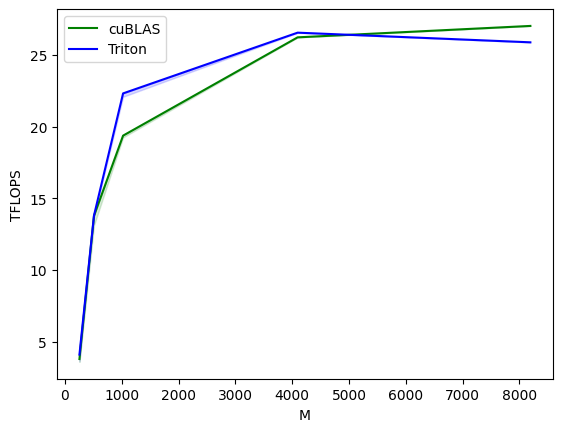

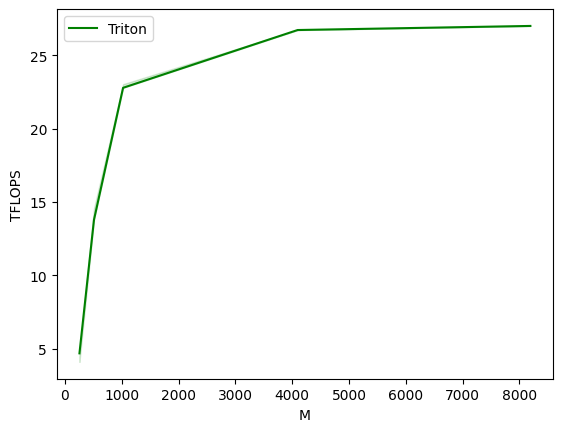

In [ ]:

torch.manual_seed(0)
a = torch.rand((512, 512), device=DEVICE, dtype=torch.float16) - 0.5
b = torch.rand((512, 512), device=DEVICE, dtype=torch.float16) - 0.5
triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)
#print(f"triton_output_with_fp16_inputs={triton_output}")
#print(f"torch_output_with_fp16_inputs={torch_output}")

if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
if TORCH_HAS_FP8:
    torch.manual_seed(0)
    a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    a = a.to(torch.float8_e5m2)
    # pre-transpose b for efficiency.
    b = b.T
    b = b.to(torch.float8_e5m2)
    triton_output = matmul(a, b)
    torch_output = torch.matmul(a.to(torch.float16), b.to(torch.float16))
    #print(f"triton_output_with_fp8_inputs={triton_output}")
    #print(f"torch_output_with_fp8_inputs={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

# %%
# Benchmark
# ---------
#
# Square Matrix Performance
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# We can now compare the performance of our kernel against that of cuBLAS or rocBLAS. Here we focus on square matrices,
# but feel free to arrange this script as you wish to benchmark any other matrix shape.

ref_lib = 'cuBLAS'

configs = []
for fp8_inputs in [False, True]:
    if fp8_inputs and (not TORCH_HAS_FP8):
        continue
    configs.append(
        triton.testing.Benchmark(
            x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
            x_vals=[256, 512, 1024, 4096, 8192],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=["triton"] if fp8_inputs else [ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=["Triton"] if fp8_inputs else [ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-" +
            ("fp16" if not fp8_inputs else "fp8"),  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        b = b.T
        b = b.to(torch.float8_e5m2)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=False, print_data=True)